# Reinforcement learning summer school at the VU - 2022

## Workshop tutorial, day 2: 

## Deep Reinforcement Learning Agent (Part 2)


### Author: Buelent Uendes 

In this notebook, we will use a function approximator to solve the mountain car game. As seen in the previous notebook, a simple agent that uses Q learning can learn to move the car in a way to move up the hill. Yet, for this to work, one had to discretize the state space. However, for large problems this approach is not feasible, given the fact that we then have a state,action pair matrix. To overcome this, we will use a Neural Network that will approximate the state, pair values. For this, we will use PyTorch. If you have not used PyTorch yet, do not worry, as the code will be provided. Yet, if you want to have a more in-depth tutorial in PyTorch, you can use the following YouTube tutorial:

- https://www.youtube.com/watch?v=c36lUUr864M

Deep reinforcement learning got popular following the paper published in 2013 [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf). Following this paper, several additional techniques were introduced that aim to stabilize the learning process. In the following notebook, we will look at two new methods, memory replay and target networks and will try to solve the mountain car environment using a Deep Reinforcement Learning algorithm. 

This notebook is inspired by the implementation of a Deep Q agent as discussed in this [tutorial](https://www.youtube.com/watch?v=NP8pXZdU-5U)

**Instructions:**

In the notebook, you will see a couple of ToDos with some instructions. Try your best to work through them and to complete the notebook. In case you run into problems, do not hesitate to ask any of the TAs for help! :) 

## Preliminaries 

### Import main libraries 

In [1]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque
from mpl_toolkits import mplot3d

### Seeting the seed for reproducibility 

In [2]:
# Seed
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

## General notes 

We will introduce the concept of Deep Reinforcement Learning in **three** steps:

1) First introduce how to implement a simple deep neural network that is represents an essential building block of Deep Q learning

2) Introduce the topic of experience replay/replay buffer

3) Introduce the concept of a target network!

## Part 1: Deep neural network and its general characteristics in the context of reinforcement learning

### General characteristics of Deep Q learning

In the simplest approach, a Deep RL algorithm is:

- Episodic (the agent acts in the environment only for a specific number of timesteps)
- Online (we train the algorithm while the agent interacts with the environment)
- Model-free. We do not attempt to model the environment.

In the following, we will implement a deep neural network using the PyTorch library. 

In [3]:
class DQN(nn.Module):
    
    def __init__(self, env, learning_rate):
        
        super(DQN,self).__init__()
        
        '''
        ToDo: Write your code here! 
        Make sure that the input features and the output features are in line with the environment that 
        the class takes as an input feature
        '''
        
        'Solution:'
        input_features = env.observation_space.shape[0]
        action_space = env.action_space.n
        
        self.dense1 = nn.Linear(in_features = input_features, out_features = 128)
        self.dense2 = nn.Linear(in_features = 128, out_features = 64)
        self.dense3 = nn.Linear(in_features = 64, out_features = 32)
        self.dense4 = nn.Linear(in_features = 32, out_features = action_space)
        
        self.optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        
        
    def forward(self, x):
        
        '''
        ToDo: Write the forward pass! Keep in mind that the final layer should have as
        many output features as there are actions!
        
        Important: We want to output a linear activation function as we need the q-values associated with each action
    
        '''
        
        'Solution:'
        x = torch.tanh(self.dense1(x))
        x = torch.tanh(self.dense2(x))
        x = torch.tanh(self.dense3(x))
        x = self.dense4(x)
        
        return x
    

That's it! This is the implementation of a deep neural network in PyTorch!

## Part 2: Experience replay

In a normal implementation of a deep neural network, one would train the algorithm using some sort of a gradient method. Yet, one of the key assumption is that the data is iid, i.e. independent identically distributed which does not hold in our reinforcement learning setting. The next state and its reward depends on the action our agent took the preceeding state which makes subsequent states and the data highly correlated. This can cause the DQN to be instable. To circumvent this, people use in practice a so-called experience replay technique. The main rationale behind this idea is to break the correlation between subsequent transitions by saving experiences in memory and sample randomly from the stored transitions when performing a Q-value update. This 'trick' is essential to make the method work!

In the following, we will create a experience replay class that will store the transitions of the deep Q agent. It is important to keep in mind that the replay buffer has a fixed capacity. If the data that we want to store in the replay buffer exceeds the buffer, we want to store only the most recent transitions in the buffer. 

In [4]:
class ExperienceReplay:
    
    def __init__(self, env, buffer_size, min_replay_size = 1000):
        
        self.env = env
        self.min_replay_size = min_replay_size
        self.replay_buffer = deque(maxlen=buffer_size)
        self.reward_buffer = deque([0.0], maxlen = 100)
        
        print('Please wait, the experience replay buffer will be filled with random transitions')
        
        '''
        ToDo: 
        Write a for loop that initializes the experience replay buffer with random transitions 
        such that the experience replay buffer 
        has minimum random transitions already stored 
        '''
        
        'Solution'
        obs = self.env.reset()
        
        #Write your code here!
        for _ in range(self.min_replay_size):
            
            action = env.action_space.sample()
            new_obs, rew, done, _ = env.step(action)
            transition = (obs, action, rew, done, new_obs)
            self.replay_buffer.append(transition)
            obs = new_obs
    
            if done:
                obs = env.reset()
        
        #Logging
        print('Initialization with random transitions is done!')
      
          
    def add_data(self, data):      
        self.replay_buffer.append(data)
            
    def sample(self, batch_size):
        
        transitions = random.sample(self.replay_buffer, batch_size)

        observations = np.asarray([t[0] for t in transitions])
        actions = np.asarray([t[1] for t in transitions])
        rewards = np.asarray([t[2] for t in transitions])
        dones = np.asarray([t[3] for t in transitions])
        new_observations = np.asarray([t[4] for t in transitions])

        observations_t = torch.as_tensor(observations, dtype = torch.float32)
        actions_t = torch.as_tensor(actions, dtype = torch.int64).unsqueeze(-1)
        rewards_t = torch.as_tensor(rewards, dtype = torch.float32).unsqueeze(-1)
        dones_t = torch.as_tensor(dones, dtype = torch.float32).unsqueeze(-1)
        new_observations_t = torch.as_tensor(new_observations, dtype = torch.float32)
        
        return observations_t, actions_t, rewards_t, dones_t, new_observations_t
    
    def add_reward(self, reward):
        self.reward_buffer.append(reward)
        

##  Write policy for choosing the optimal policy 

In [5]:
def epsilon_greedy_action(env, online_network, observation, step, 
                          epsilon_decay, epsilon_start, epsilon_end):
    
    epsilon = np.interp(step, [0, epsilon_decay], [epsilon_start, epsilon_end])
    
    random_sample = random.random()
    
    '''
    ToDo: write the function here that returns an action that is chosen based on the epsilon greedy policy
    '''
    
    'Solution:'
    
    #Random action
    if random_sample <= epsilon:
        action = env.action_space.sample()
        
    #Greedy action
    else:
        obs_t = torch.as_tensor(observation, dtype = torch.float32)
        q_values = self.net(obs_t.unsqueeze(0))
        
        max_q_index = torch.argmax(q_values, dim = 1)[0]
        action = max_q_index.detach().item()
        
    return action, epsilon

## Write the code for the vanilla DQN agent 

In [6]:
class vanilla_DQNAgent:
    
    def __init__(self, en, device, epsilon_decay, 
                 epsilon_start, epsilon_end, discount_rate, lr, buffer_size):
        
        self.env = env
        self.discount_rate = discount_rate
        self.device = device
        
        self.epsilon_decay = epsilon_decay
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        
        self.discount_rate = discount_rate
        self.learning_rate = lr
        self.buffer_size = buffer_size
        
        self.replay_memory = ExperienceReplay(self.env, self.buffer_size)
        self.online_network = DQN(self.env, self.learning_rate).to(self.device)
        
    def choose_action(self, step, observation, greedy = False):
        
        '''
        Copy paste your epsilon greedy function that you wrote above!
        '''
        
        epsilon = np.interp(step, [0, self.epsilon_decay], [self.epsilon_start, self.epsilon_end])
    
        random_sample = random.random()
    
        if (random_sample <= epsilon) and not greedy:
            #Random action
            action = self.env.action_space.sample()
        
        else:
            obs_t = torch.as_tensor(observation, dtype = torch.float32)
            q_values = self.online_network(obs_t.unsqueeze(0))
        
            max_q_index = torch.argmax(q_values, dim = 1)[0]
            action = max_q_index.detach().item()
        
        return action, epsilon
    
    def learn(self, batch_size):
        
        observations_t, actions_t, rewards_t, dones_t, new_observations_t = self.replay_memory.sample(batch_size)

        #Compute targets, note that we use the same neural network to do both! This will be changed later!
        
        '''ToDo:
        Calculate the target q values and the corresponding max q values!
        '''
        
        'Solution:'
        target_q_values = self.online_network(new_observations_t)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]

        targets = rewards_t + self.discount_rate * (1-dones_t) * max_target_q_values

        #Compute loss

        q_values = self.online_network(observations_t)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

        #Loss, here we take the huber loss!
        
        'ToDo: Implement here the loss function! You can choose the standard MSE loss or Huber loss'

        'Solution:'
        loss = F.smooth_l1_loss(action_q_values, targets)
        
        #loss = F.mse_loss(action_q_values, targets)
        
        'ToDo: Write the gradient descent step, were you optimize the online network based on the loss!'
        
        'Solution:'
        #Gradient descent
        self.online_network.optimizer.zero_grad()
        loss.backward()
        self.online_network.optimizer.step()
        

## Write the training loop and perform the first run!

In a last step, we can write a training loop that will put all things together. We will run the training loop for a number of iteration and see how our first algorithm performs!

### Hyperparameters 

In [7]:
#Set the hyperparameters

#Discount rate
discount_rate = 0.99
#That is the sample that we consider to update our algorithm
batch_size = 32
#Maximum number of transitions that we store in the buffer
buffer_size = 50000

min_replay_size = 1000
epsilon_start = 1.0
epsilon_end = 0.05
#Decay period until epsilon start -> epsilon end
epsilon_decay = 10000

max_episodes = 250000

lr = 5e-4

### Set the environment

In [8]:
#Check if this works
env = gym.make('MountainCar-v0')

### Initialize all instances 

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vanilla_agent = vanilla_DQNAgent(env, device, epsilon_decay, epsilon_start, epsilon_end, discount_rate, lr, buffer_size)

Please wait, the experience replay buffer will be filled with random transitions
Initialization with random transitions is done!


### Main training loop - vanilla DQN algorithm

In [10]:
#Main training loop
env.action_space.seed(1)
obs = env.reset()
#Have a list that stores average reward over 100 runs
average_rewards_vanilla_dqn = [0]
episode_reward = 0.0

for step in range(max_episodes):
    
    action, epsilon = vanilla_agent.choose_action(step, obs)
       
    new_obs, rew, done, _ = env.step(action)
    transition = (obs, action, rew, done, new_obs)
    vanilla_agent.replay_memory.add_data(transition)
    obs = new_obs
    
    episode_reward += rew
    
    if done:
        
        obs = env.reset()
        vanilla_agent.replay_memory.add_reward(episode_reward)
        #Reinitilize the reward to 0.0 after the game is over
        episode_reward = 0.0

#Learn

    vanilla_agent.learn(batch_size)

    #Calculate after each 100 episodes an average that will be added to the list
    
    if (step+1) % 100 == 0:
        average_rewards_vanilla_dqn.append(np.mean(vanilla_agent.replay_memory.reward_buffer))
    
    #Logging
    if step % 10000 == 0:
        print(20*'--')
        print('Step', step)
        print('Epsilon', epsilon)
        print('Avg Rew', np.mean(vanilla_agent.replay_memory.reward_buffer))
        print()


----------------------------------------
Step 0
Epsilon 1.0
Avg Rew 0.0

----------------------------------------
Step 10000
Epsilon 0.05
Avg Rew -196.07843137254903

----------------------------------------
Step 20000
Epsilon 0.05
Avg Rew -200.0

----------------------------------------
Step 30000
Epsilon 0.05
Avg Rew -200.0

----------------------------------------
Step 40000
Epsilon 0.05
Avg Rew -200.0

----------------------------------------
Step 50000
Epsilon 0.05
Avg Rew -200.0

----------------------------------------
Step 60000
Epsilon 0.05
Avg Rew -200.0

----------------------------------------
Step 70000
Epsilon 0.05
Avg Rew -200.0

----------------------------------------
Step 80000
Epsilon 0.05
Avg Rew -200.0

----------------------------------------
Step 90000
Epsilon 0.05
Avg Rew -200.0

----------------------------------------
Step 100000
Epsilon 0.05
Avg Rew -200.0

----------------------------------------
Step 110000
Epsilon 0.05
Avg Rew -200.0

---------------------

**Comment**: As you can see, the vanilla deep Q network performs very poorly and does not learn to master the challenge. Play around with the number of iterations and epsilon decay to check if you can improve the algorithm!

## Part 3: Target network

A problem of the standard Q learning introduced above is the fact that we use the same Q value to choose an action and to evaluate it. To overcome this problem, double-Q learning was proposed in the following paper [Double Q-learning](https://papers.nips.cc/paper/2010/file/091d584fced301b442654dd8c23b3fc9-Paper.pdf).
In the case of DQN, we can make use of the same idea by training a second neural network,a so-called target network. Just as the name suggests, the target network will be used to compute the target of the update equation using this target network. This target network will only be updated after a pre-defined number of steps to ensure that the target will not move as the DQN network will learn (as it is the case in the standard simple DQN framework). This idea was put forward in the paper again by van Hasselt et al. (2016) [Deep reinforcement learning with double Q-learning](https://arxiv.org/pdf/1509.06461.pdf). 


Implementing a target network and changing the architecture to a double DQN is rather straightforward. All we need to do is to initialize besides an online network a so-called target network. After a specific number of steps, the parameter values of the target network are reinitialized with the online network after a pre-defined number of steps. For this, we will add a few lines to the vanilla DQN class and call it DDQN (for double deep Q learning).

In [10]:
class DDQNAgent:
    
    def __init__(self, en, device, epsilon_decay, 
                 epsilon_start, epsilon_end, discount_rate, lr, buffer_size):
        
        self.env = env
        self.discount_rate = discount_rate
        self.device = device
        
        self.epsilon_decay = epsilon_decay
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        
        self.learning_rate = lr
        self.buffer_size = buffer_size
        
        self.replay_memory = ExperienceReplay(self.env, self.buffer_size)
        self.online_network = DQN(self.env, self.learning_rate).to(self.device)
        
        '''
        ToDo: 'Add here a target network and set the parameter values to the ones of the online network!'
        '''
        
        'Solution'
        self.target_network = DQN(self.env, self.learning_rate).to(self.device)
        self.target_network.load_state_dict(self.online_network.state_dict())
        
    def choose_action(self, step, observation, greedy = False):
        
        '''
        Copy paste here the code from above!
        '''
        
        epsilon = np.interp(step, [0, self.epsilon_decay], [self.epsilon_start, self.epsilon_end])
    
        random_sample = random.random()
    
        if (random_sample <= epsilon) and not greedy:
            #Random action
            action = self.env.action_space.sample()
        
        else:
            obs_t = torch.as_tensor(observation, dtype = torch.float32)
            q_values = self.online_network(obs_t.unsqueeze(0))
        
            max_q_index = torch.argmax(q_values, dim = 1)[0]
            action = max_q_index.detach().item()
        
        return action, epsilon
    
    #We will need this function later for plotting the 3D graph
    def return_q_value(self, observation):
        obs_t = torch.as_tensor(observation, dtype = torch.float32)
        q_values = self.online_network(obs_t.unsqueeze(0))
        
        return torch.max(q_values).item()
        
    def learn(self, batch_size):
        
        observations_t, actions_t, rewards_t, dones_t, new_observations_t = self.replay_memory.sample(batch_size)

        #Compute targets, note that we use the same neural network to do both! This will be changed later!

        target_q_values = self.target_network(new_observations_t)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]

        targets = rewards_t + self.discount_rate * (1-dones_t) * max_target_q_values

        #Compute loss

        q_values = self.online_network(observations_t)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

        #Loss, here we take the huber loss!

        loss = F.smooth_l1_loss(action_q_values, targets)
        
        #loss = F.mse_loss(action_q_values, targets)
        
        #Gradient descent
        self.online_network.optimizer.zero_grad()
        loss.backward()
        self.online_network.optimizer.step()
        
    '''
    ToDO: Write a method 'update_target_network(self), 
    which updats the target network with the parameters of the online network
    '''
    
    'Solution'
    def update_target_network(self):
        self.target_network.load_state_dict(self.online_network.state_dict())
    
    #This method will let the DQNAgent play the game after it has worked through the number of episodes for training
    
    def play_game(self, step):
        #Get the optimized strategy:
        done = False
        #Start the game
        state = self.env.reset()
        while not done:
            #Pick the best acction from the saved Qtable
            action = self.choose_action(step, state, True)[0]
            next_state, reward, done, info = self.env.step(action)
            state = next_state
            self.env.render()
            #Pause to make it easier to watch
            time.sleep(0.05)
        #Close the pop-up window
        self.env.close()
    

After we have created our DDQNAgent class, we can re-run the experiment from above and see if we can increase the performance! 

## Hyperparameters and initialization 

Since the hyperparameters are the same as before, we only need to set the new hyperparameter target_update_frequency.

In [11]:
#Set the new hyperparameters
target_update_frequency = 250

In [12]:
dagent = DDQNAgent(env, device, epsilon_decay, epsilon_start, epsilon_end, discount_rate, lr, buffer_size)

Please wait, the experience replay buffer will be filled with random transitions
Initialization with random transitions is done!


### Main loop DDQN - double deep Q network

In [14]:
#Main training loop
env.action_space.seed(42)
obs = env.reset()
#Have a list that stores average reward over 100 runs
average_rewards_ddqn = [0]
episode_reward = 0.0

for step in range(max_episodes):
    
    action, epsilon = dagent.choose_action(step, obs)
       
    new_obs, rew, done, _ = env.step(action)
    transition = (obs, action, rew, done, new_obs)
    dagent.replay_memory.add_data(transition)
    obs = new_obs
    
    episode_reward += rew
    
    if done:
        
        obs = env.reset()
        dagent.replay_memory.add_reward(episode_reward)
        #Reinitilize the reward to 0.0 after the game is over
        episode_reward = 0.0

#Learn

    dagent.learn(batch_size)

#Calculate after each 100 episodes an average that will be added to the list
    
    if (step+1) % 100 == 0:
        average_rewards_ddqn.append(np.mean(dagent.replay_memory.reward_buffer))
    
    
#Update target network
    if step % target_update_frequency == 0:
        dagent.update_target_network()
    
#Logging
    if step % 10000 == 0:
        print(20*'--')
        print('Step', step)
        print('Epsilon', epsilon)
        print('Avg Rew', np.mean(dagent.replay_memory.reward_buffer))
        print(20*'--')

----------------------------------------
Step 0
Epsilon 1.0
Avg Rew 0.0
----------------------------------------
----------------------------------------
Step 10000
Epsilon 0.05
Avg Rew -196.07843137254903
----------------------------------------
----------------------------------------
Step 20000
Epsilon 0.05
Avg Rew -198.69
----------------------------------------
----------------------------------------
Step 30000
Epsilon 0.05
Avg Rew -198.21
----------------------------------------
----------------------------------------
Step 40000
Epsilon 0.05
Avg Rew -199.52
----------------------------------------
----------------------------------------
Step 50000
Epsilon 0.05
Avg Rew -200.0
----------------------------------------
----------------------------------------
Step 60000
Epsilon 0.05
Avg Rew -198.7
----------------------------------------
----------------------------------------
Step 70000
Epsilon 0.05
Avg Rew -197.55
----------------------------------------
-----------------------

**Comments**:

As you can see, implementing a target network improved the performance of the deep reinforcement learning algorithm greatly! 

We can also plot the results of both algorithms to see the difference even more clearly.


**Comment**:

Here we can plot the results of the algorithms. 

Text(0, 0.5, 'Average reward')

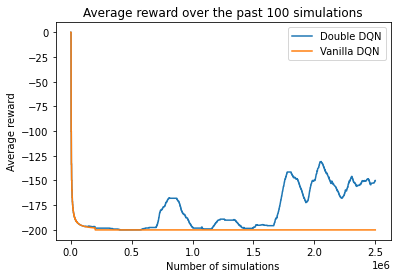

In [15]:
plt.plot(1000*(np.arange(len(average_rewards_ddqn))+1),average_rewards_ddqn)
plt.plot(1000*(np.arange(len(average_rewards_vanilla_dqn))+1),average_rewards_vanilla_dqn)
plt.title('Average reward over the past 100 simulations')
plt.xlabel('Number of simulations')
plt.legend(['Double DQN', 'Vanilla DQN'])
plt.ylabel('Average reward')

You can play around the hyperparameter and see how the results change if, for example, you lower the discount rate or learning rate! Also, you can see if changing the neural network architecture, i.e. making it deeper, will lead to an increase in performance.

## Reap the rewards of the hard work - see the DDQN play the game! 

Now that we worked through two different deep reinforcement learning architectures, we can see the DQN solve the game. The code below with let the DQNAgent play the mountain car game. 

In [47]:
dagent.play_game(max_episodes)

## Visualize the result in a 3D plot 

**ToDo!**

We can visualize the result in a 3D plot, plotting the x-position as well as the velocity with the corresponding value function. To recall, the value of a particular state is, in case of a greedy policy, the corresponding maximum state action pair! The following function will plot the value function.

## Extensions/Interesting notes: 

Following the sucess of the paper by Minh et al. (2013), research in deep reinforcement learning has progressed and a couple of extensions to the basic framework have been proposed, such as dueling deep Q learning (also called D3QN) and priotized experience replay. But before I give you some pointers on this, we will discuss the deadly triad in a bit more detail.


## The deadly triad 

Some of you might have heard of the term 'deadly triad' which refers to the instability a reinforcement learning algorithm faces, when an algorithm makes use of:

- function approximation
- bootstrapping
- off-policy evaluation

Our deep reinforcement learning algorithm makes use of all three concepts. Yet, it does **not** state that instability/divergence always occur when all three above-mentioned techniques are used. The deadly triad only states that it **can** occur. An interesting paper that addresses this issue empirically is the following paper by van Hasselt et al. (2018) [Deep Reinforcement Learning and the Deadly Triad](https://arxiv.org/pdf/1812.02648.pdf)

For doing this, they realize that if one bounds the rewards in the interval between $[-1,1]$, then one can show that the corresponding Q values are bounded given by the following equation:

$  \sum_{t'=t}^{T} \gamma^{t'-t} |r_{t'}| \le \sum_{t'=t}^{\infty} \gamma^{t'-t} |r_{t'}| \le \sum_{t'=t}^{\infty} \gamma^{t'-t} = \frac{1}{1-\gamma}  $

According to this, any Q-value is theoretically bounded by the above equation. In our case, by $100$ (given a discount rate of $0.99$). Hence, if the Q-value exceeds this bound, we say that soft divergence occurs.

## Priotized experience replay 

**To be done**

Here I will ad a few comments about priotized experience replay.


## Dueling Deep Reinforcement learning -D3QN

**To be done**

Here I will add a few lines over D3QN.

This tutorial is inspired by Pylessons. You can find the tutorials here [Pylessons](https://pylessons.com/CartPole-DDDQN). The idea of using a dueling deep reinforcement algorithm was introduced by [Wang et al. (2016).](https://arxiv.org/pdf/1511.06581.pdf).

[medium](https://markelsanz14.medium.com/introduction-to-reinforcement-learning-part-4-double-dqn-and-dueling-dqn-b349c9a61ea1)